## Synthetic SAEM modelling 

We will do some synthetic modelling of a Drone-based SAEM survey to understand the fields, investigate the influence of several acquisition parameters, and analysing resolution.

In [1]:
# First import the SAEM class and the numpy module
import numpy as np
from saem import CSEMData

### Definition of the frequency axis

In [2]:
df = 0.5  # 0.5/1 for half/full octave
fMin, fMax = 32, 25000
f = np.round(2**np.arange(0, np.log2(fMax/fMin), df) * fMin)
print(f)

[   32.    45.    64.    91.   128.   181.   256.   362.   512.   724.
  1024.  1448.  2048.  2896.  4096.  5793.  8192. 11585. 16384. 23170.]


The higher frequencies follow the half-octave processing scheme. However, there are some lower frequencies that are normally not processed. We will get rid of them

In [3]:
f = np.hstack((f[3], f[5:-3], f[-3:]))
print(f)

[   91.   181.   256.   362.   512.   724.  1024.  1448.  2048.  2896.
  4096.  5793.  8192. 11585. 16384. 23170.]


### Acquisition parameters
Assume we have a South-North (y) trending transmitter and a receiver line along the x axis.
We initialize the CSEMdata class passing the Tx/Rx positions and frequencies.

In [4]:
x = np.arange(25, 1000, 50)  # receiver positions
txLen = 500  # length of the transmitter
self = CSEMData(f=f, rx=x, txPos=np.array([[0, 0], [-txLen/2, txLen/2]]))
print(self)

CSEM data with 20 stations and 16 frequencies
Transmitter length 500m
Sounding pos at 25.000000,0.000000,-0.000000,


Assume a two layer model of a freshwater aquifer above a clay layer situated at a depth of 100m. 
In the following we are only interested in the Bx and Bz component.

In [5]:
self.simulate(rho=[300, 20], thk=[100])
self.cmp = [1, 0, 1]

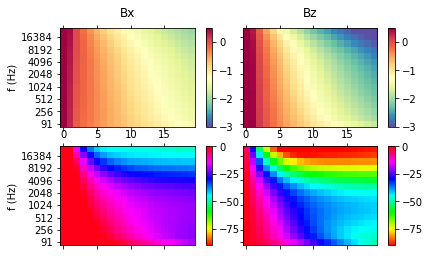

In [6]:
# We show the data along the line using the same amplitude and phase scale
self.showLineData(alim=[-3, 0.5], plim=[-90, 0]);


The amplitudes of both components decrease with increasing distance and frequency. Whereas both components are similar close to the transmitter, the z component decreases way faster and is therefore more prone to noise. On the other hand, the phase shift is stronger for Bz.

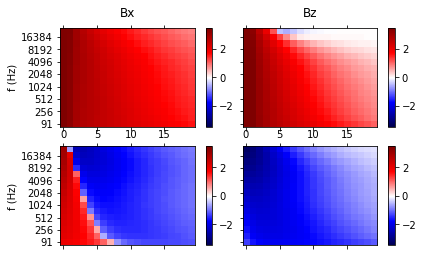

In [8]:
# We can also show real and imaginary part of the data. 
# As we don't see much in a linear scale, we use a symlog scale (decades over threshold).
self.showLineData(cmp=[1, 0, 1], amphi=False, log=1e-3, alim=[-3, 3]);

The good conductor generates a significant imaginary (induction) part on the whole frequency axis, which however decreases rapidly with distance.

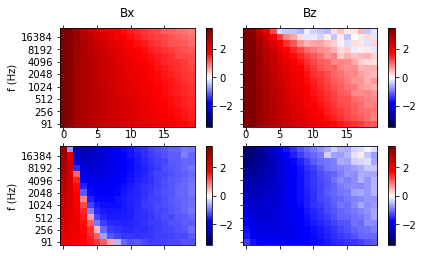

In [12]:
# We now add some random noise.
from numpy.random import randn
noiseLevel = 1e-3  # nV/A
sh = self.DATAX.shape
for cmp in ["X", "Y", "Z"]:
    noise = (randn(*sh) + randn(*sh) * 1j) * noiseLevel
    setattr(self, "DATA"+cmp, getattr(self, "DATA"+cmp) + noise)

self.showLineData(cmp=[1, 0, 1], amphi=False, log=1e-3, alim=[-3, 3]);

We easily see that the Bz component runs into noise for distances above 700m (1 kHz).
For higher frequency, noise already starts at 300m distance.

To the contrary, the Bx component is stable on the whole x axis.

We can also look how this looks expressed in amplitude and phase.

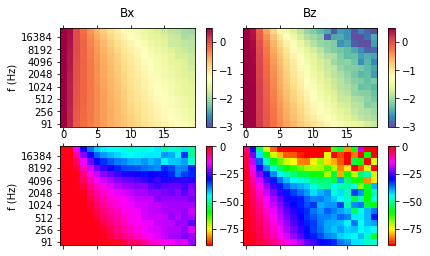

In [14]:
self.showLineData(alim=[-3, 0.5], plim=[-90, 0]);

Here we see that the Bx phases become noise at about 700m distance, the Bz phases already below 500. Note that there is no frequency dependence anymore, only for the Bz amplitude.

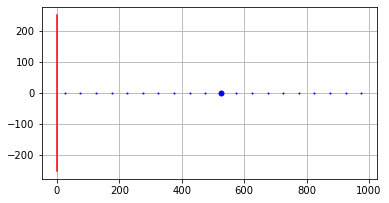

In [16]:
# We choose a sounding about 500m from the transmitter
self.setPos(10, show=True)

30/12/21 - 16:28:24 - pyGIMLi - INFO - Startmodel set from given array. 16 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
30/12/21 - 16:28:24 - pyGIMLi - INFO - Starting inversion.


[  -0.           -5.397453    -13.30480844  -23.72206632  -36.64922664
  -52.0862894   -70.03325459  -90.49012222 -113.45689229 -138.9335648
 -166.92013975 -197.41661714 -230.42299696 -265.93927922 -303.96546392
 -344.50155106]
fop: <saem.modelling.fopSAEM object at 0x000002A314F4BE30>
Data transformation: <pgcore._pygimli_.RTransLin object at 0x000002A3152ECF30>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002A315426670>
min/max (data): -0.047/0.17
min/max (error): 3.60%/248%
min/max (start model): 1/1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 414.23 (dPhi = 0.0%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 414.23 (dPhi = 0.0%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 414.23 (dPhi = 0.0%

16 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

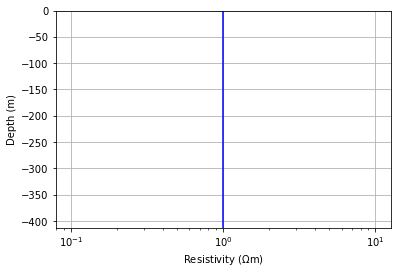

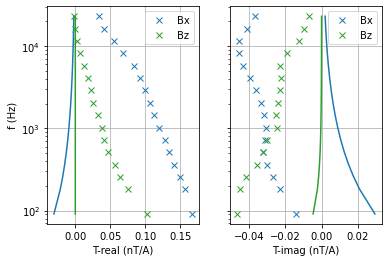

In [28]:
self.createDepthVector(rho=30)
print(self.depth)
# self.invertSounding(absError=noiseLevel, lam=10, cmp=[1, 0, 0])